# Scoring model based on LightGBM

In [1]:
import os
import warnings
import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
from category_encoders import WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import metrics
import lightgbm as lgb

from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_validate,
    cross_val_score
)
from sklearn.pipeline import Pipeline

# Global parameters
N_SPLITS = 5
N_REPEATS = 10
SEED = 42
TRIALS = 150

# Settings
np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})  # `standard number format` mode
pd.set_option("display.max_columns", None)                                # `show whole df` mode
warnings.filterwarnings("ignore")                                         # `do not disturbe` mode
sns.set_context("paper", font_scale=1.4)                                  # sns font
sns.set_style("darkgrid")                                                 # sns theme

In [2]:
def objective(trial):
    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    model = lgb.LGBMClassifier(**param, random_state=SEED)

    # Cross-validation
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    scores = cross_val_score(model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv)
    mean_val_auc = scores.mean()

    return mean_val_auc * 2 - 1

In [3]:
# Load data
X_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_train.csv"))
X_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_test.csv"))
y_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "y_train.csv"))
y_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "y_test.csv"))

dtrain = lgb.Dataset(X_train, label=y_train)

print(X_train.shape)
print(X_test.shape)

(20000, 23)
(10000, 23)


### Feature selection

In [4]:
%%time
# Initial hyperparameters optimization
study = optuna.create_study(directions=["maximize"])
study.optimize(objective, n_trials=TRIALS, n_jobs=-1)
print(study.best_params)

[I 2021-05-24 21:56:23,145] A new study created in memory with name: no-name-e8fa3570-38fe-47f4-91e8-ddb73db26d4f
[I 2021-05-24 21:56:43,552] Trial 3 finished with value: 0.5106949491116481 and parameters: {'n_estimators': 121, 'lambda_l1': 0.3118462844416355, 'lambda_l2': 2.1757499040850234e-05, 'num_leaves': 123, 'feature_fraction': 0.8345554326591142, 'bagging_fraction': 0.4527182586073496, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 3 with value: 0.5106949491116481.
[I 2021-05-24 21:56:52,982] Trial 2 finished with value: 0.5168905314339276 and parameters: {'n_estimators': 159, 'lambda_l1': 1.2032788531783652e-08, 'lambda_l2': 0.028861282520516836, 'num_leaves': 247, 'feature_fraction': 0.636791826195424, 'bagging_fraction': 0.8433902776512305, 'bagging_freq': 7, 'min_child_samples': 70}. Best is trial 2 with value: 0.5168905314339276.
[I 2021-05-24 21:56:54,600] Trial 4 finished with value: 0.5300148139546279 and parameters: {'n_estimators': 98, 'lambda_l1': 0.00019

{'n_estimators': 248, 'lambda_l1': 2.0399738641447258e-05, 'lambda_l2': 9.466456930809223, 'num_leaves': 4, 'feature_fraction': 0.740200900753696, 'bagging_fraction': 0.5083905950412057, 'bagging_freq': 5, 'min_child_samples': 8}
Wall time: 12min 19s


In [5]:
# Sequential feature selection
model = lgb.LGBMClassifier(**study.best_params, random_state=SEED)

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
sfs = SequentialFeatureSelector(
    model,
    k_features=23,
    forward=True,
    floating=True,
    scoring="roc_auc",
    verbose=2,
    cv=cv,
    n_jobs=-1,
)

sfs = sfs.fit(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:   17.1s finished

[2021-05-24 22:09:00] Features: 1/23 -- score: 0.7116959206440738[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished

[2021-05-24 22:09:16] Features: 2/23 -- score: 0.7116959206440738[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s finished

[2021-05-24 22:09:35] Features: 3/23 -- score: 0.7365857773909174[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent 

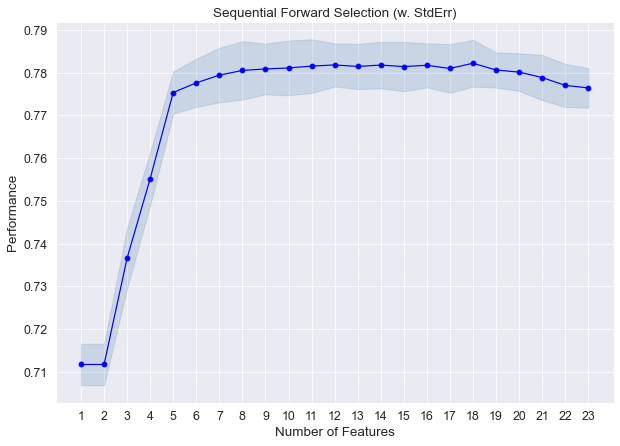

In [6]:
# Plot SFS chart
fig = plot_sfs(sfs.get_metric_dict(), kind="std_err", figsize=[10, 7])
plt.title("Sequential Forward Selection (w. StdErr)")

plt.savefig(os.path.join("Experiment_results", "LightGBM", "lgb_SFS.png"), facecolor="w")

In [7]:
# Print chosen variables
results = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
final_variables = list(results["feature_names"][10])
final_variables

['LIMIT_BAL',
 'EDUCATION',
 'PAY_0',
 'PAY_2',
 'PAY_4',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'PAY_AMT2']

In [8]:
# Drop unused variables
X_train = X_train[final_variables]
X_test = X_test[final_variables]

### Model

In [9]:
%%time
start = time.time()

# Hyperparameters optimization
study = optuna.create_study(directions=["maximize"])
study.optimize(objective, n_trials=TRIALS, n_jobs=-1)

end = time.time()
optimization_time = end-start

print(study.best_params)

# Model definition
model = lgb.LGBMClassifier(**study.best_params, random_state=SEED)

[I 2021-05-24 22:18:45,107] A new study created in memory with name: no-name-31f5677d-e696-4c8d-84d1-0e07b633f5b5
[I 2021-05-24 22:18:49,167] Trial 2 finished with value: 0.5507492375075262 and parameters: {'n_estimators': 91, 'lambda_l1': 3.8480537666504313, 'lambda_l2': 0.0028936893784686046, 'num_leaves': 202, 'feature_fraction': 0.9448994181886166, 'bagging_fraction': 0.44012619913764295, 'bagging_freq': 5, 'min_child_samples': 94}. Best is trial 2 with value: 0.5507492375075262.
[I 2021-05-24 22:18:50,968] Trial 0 finished with value: 0.5464363640575418 and parameters: {'n_estimators': 268, 'lambda_l1': 0.00013519773829765225, 'lambda_l2': 0.00017117563248488527, 'num_leaves': 16, 'feature_fraction': 0.6044768214574765, 'bagging_fraction': 0.9136682694415316, 'bagging_freq': 1, 'min_child_samples': 85}. Best is trial 2 with value: 0.5507492375075262.
[I 2021-05-24 22:18:55,462] Trial 5 finished with value: 0.5473873774587177 and parameters: {'n_estimators': 101, 'lambda_l1': 0.043

{'n_estimators': 69, 'lambda_l1': 9.593044894627356, 'lambda_l2': 0.0006099401268883923, 'num_leaves': 44, 'feature_fraction': 0.4868204777615347, 'bagging_fraction': 0.7069250159835003, 'bagging_freq': 3, 'min_child_samples': 29}
Wall time: 4min 55s


In [10]:
# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
scores = cross_validate(
    model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True, n_jobs=-1
)
mean_train_auc = scores["train_score"].mean()
mean_val_auc = scores["test_score"].mean()
std_val_auc = scores["test_score"].std()

# Test
model.fit(X=X_train, y=np.ravel(y_train))
preds = model.predict_proba(X_test)[::, 1]
test_auc = metrics.roc_auc_score(y_test, preds)
ap = metrics.average_precision_score(y_test, 1-preds, pos_label=0)

# Print the results
print(f"mean_train_GINI:\t {np.round(mean_train_auc * 2 - 1, 4)}")
print("mean_dev_GINI:\t\t", np.round(mean_val_auc * 2 - 1, 4), f"({np.round(std_val_auc, 4)})")
print(f"test_GINI:\t\t {np.round(test_auc * 2 - 1, 4)}")
print(f"AP:\t\t\t {np.round(ap, 4)}")

[LightGBM] [Warning] feature_fraction is set=0.4868204777615347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4868204777615347
[LightGBM] [Warning] lambda_l1 is set=9.593044894627356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.593044894627356
[LightGBM] [Warning] bagging_fraction is set=0.7069250159835003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7069250159835003
[LightGBM] [Warning] lambda_l2 is set=0.0006099401268883923, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006099401268883923
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
mean_train_GINI:	 0.6111
mean_dev_GINI:		 0.5611 (0.0087)
test_GINI:		 0.5715
AP:			 0.5647


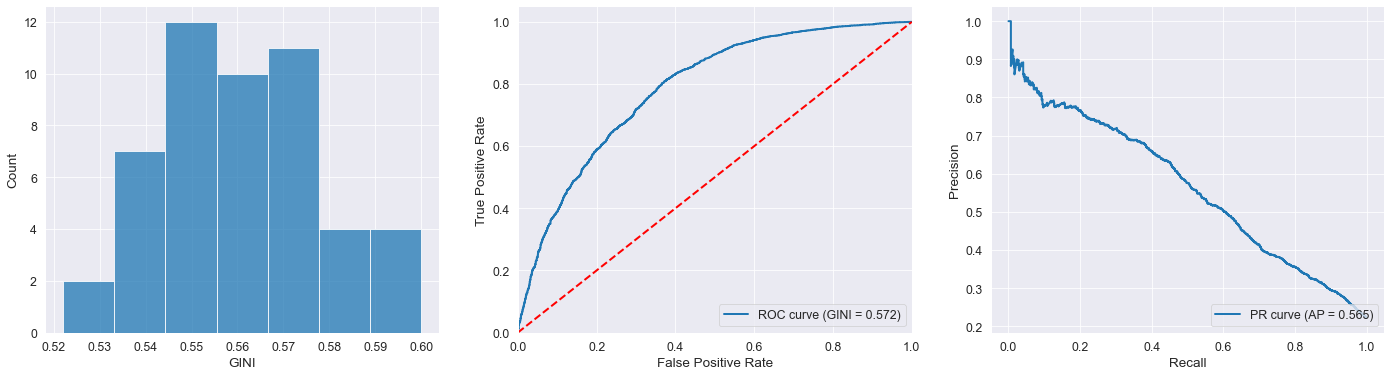

In [11]:
# Boxplot
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
fig1 = sns.histplot(scores["test_score"] * 2 - 1, ax=axs[0])
fig1.set_xlabel("GINI")

# ROC
preds = model.predict_proba(X_test)[::, 1]
test_auc = metrics.roc_auc_score(y_test, preds)

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
lw = 2
axs[1].plot(fpr, tpr, lw=lw, label="ROC curve (GINI = %0.3f)" % (test_auc * 2 - 1))
axs[1].plot([0, 1], [0, 1], color="red", lw=lw, linestyle="--")
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].legend(loc="lower right")

# PR
precision, recall, _ = metrics.precision_recall_curve(y_test, 1-preds, pos_label=0)
lw = 2
axs[2].plot(recall, precision, lw=lw, label="PR curve (AP = %0.3f)" % ap)
axs[2].set_xlabel("Recall")
axs[2].set_ylabel("Precision")
axs[2].legend(loc="lower right")

plt.savefig(os.path.join("Experiment_results", "LightGBM", "lgb_cv_roc.png"), facecolor="w")

In [12]:
# Save results for final summary
res = {
    "val_scores": scores["test_score"] * 2 - 1,
    "fpr_tpr": [fpr, tpr],
    "pr_rec": [precision, recall],
    "test_gini": test_auc * 2 - 1,
    "dev_gini": [mean_val_auc * 2 - 1, std_val_auc],
    "optimization_time": optimization_time,
    "ap": ap,
}

joblib.dump(res, os.path.join("Experiment_results", "LightGBM", "lgb_res.pth"))

['Experiment_results\\LightGBM\\lgb_res.pth']

                      0       1       2       3       4       5       6       7       8       9      10     11
score_calibrated  587.00  585.00  583.00  608.00  586.00  582.00  584.00  588.00  596.00  597.00  578.0  603.0
%Agreements         1.29    1.29    1.22    1.15    1.12    1.11    1.11    1.07    1.03    1.01    1.0    1.0


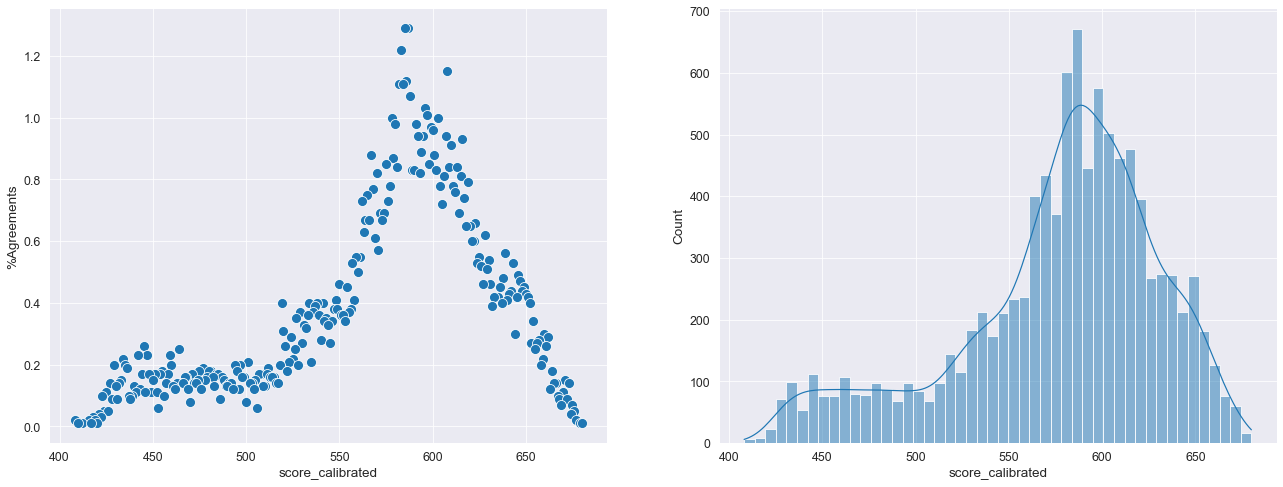

In [13]:
# Score distribution
preds_calibrated = pd.DataFrame(np.round(50*np.log(preds/(1-preds))+500), columns=["score_calibrated"])

score_distr = preds_calibrated['score_calibrated'].value_counts()/preds_calibrated.shape[0]*100
score_distr_df = pd.concat([pd.Series(list(score_distr.index), name='score_calibrated'), pd.Series(list(score_distr), name='%Agreements')], axis=1)
print(score_distr_df.head(12).T.to_string())

fig, axs = plt.subplots(1, 2, figsize=(22,8))
sns.scatterplot(data=score_distr_df, x="score_calibrated", y="%Agreements", s=100, ax=axs[0])
sns.histplot(data=preds_calibrated, x="score_calibrated", kde=True, ax=axs[1])

plt.savefig(os.path.join("Experiment_results", "LightGBM", "lgb_score_distr.png"), facecolor="w")

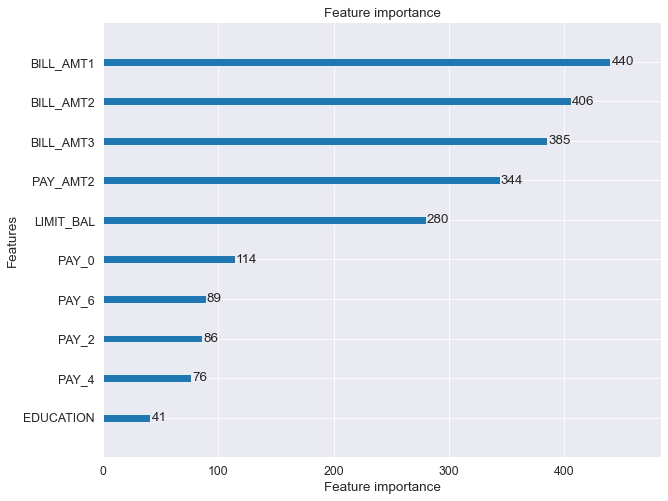

In [14]:
fig, axs = plt.subplots(1, 1, figsize=[10,8])
lgb.plot_importance(model, ax=axs, dpi=900)

plt.savefig(os.path.join("Experiment_results", "LightGBM", "lgb_fi.png"), facecolor="w")

### Performance vs sample size

In [15]:
optuna.logging.set_verbosity(optuna.logging.FATAL) # optuna silent mode

In [16]:
%%capture
# Examine relationship between model performance and sample size

n_sample = [50, 100, 500, 1000, 2000, 3000, 5000, 7000, 10000, 20000]

experiment = pd.DataFrame(n_sample, columns=["Training set size"])
experiment["Mean train GINI"] = np.NaN
experiment["Mean validation GINI"] = np.NaN
experiment["Std validation GINI"] = np.NaN
experiment["Test GINI"] = np.NaN

for i in range(len(n_sample)):
    X_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_train.csv"))[final_variables]
    X_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_test.csv"))[final_variables]
    y_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "y_train.csv"))
    y_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "y_test.csv"))

    if n_sample[i] < 20000:
        X_train = X_train.sample(n_sample[i], random_state=SEED)
        y_train = y_train.sample(n_sample[i], random_state=SEED)
        
    # Hyperparameters optimization
    study = optuna.create_study(directions=["maximize"])
    study.optimize(objective, n_trials=TRIALS, n_jobs=-1)
    print(study.best_params)

    # Model definition
    model = lgb.LGBMClassifier(**study.best_params, random_state=SEED)    
        
    # Cross-validation
    cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
    scores = cross_validate(model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True, n_jobs=-1)
    mean_train_auc = scores["train_score"].mean()
    mean_val_auc = scores["test_score"].mean()
    std_val_auc = scores["test_score"].std()

    # Test
    model.fit(X=X_train, y=np.ravel(y_train))
    preds = model.predict_proba(X_test)[::, 1]
    test_auc = metrics.roc_auc_score(y_test, preds)

    # Save the results to daraframe
    experiment["Mean train GINI"][i] = mean_train_auc * 2 - 1
    experiment["Mean validation GINI"][i] = mean_val_auc * 2 - 1
    experiment["Std validation GINI"][i] = std_val_auc
    experiment["Test GINI"][i] = test_auc * 2 - 1

In [17]:
experiment

,Training set size,Mean train GINI,Mean validation GINI,Std validation GINI,Test GINI
0,50,0.413422,0.178750,0.168978,0.120378
1,100,0.992922,0.278419,0.121475,0.455544
2,500,0.600520,0.420113,0.049652,0.514455
3,1000,0.615115,0.487859,0.032551,0.527213
4,2000,0.646307,0.548062,0.021851,0.551704
5,3000,0.613925,0.514110,0.023544,0.549507
6,5000,0.614303,0.539240,0.018950,0.561004
7,7000,0.631195,0.545488,0.012161,0.562920
8,10000,0.627104,0.561709,0.011345,0.567443
9,20000,0.608715,0.561294,0.008699,0.573201


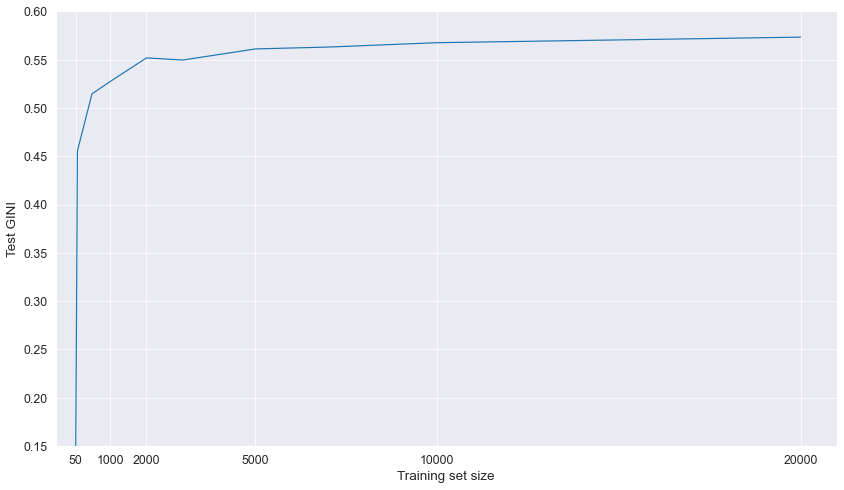

In [18]:
# Plot experiment results
fig, ax = plt.subplots(figsize=(14, 8))
sns.lineplot(data=experiment, x="Training set size", y="Test GINI")
ax.set_ylim([0.15, 0.6])
ax.set_xlim([-500, None])
ax.set_xticks([50, 1000, 2000, 5000, 10000, 20000])

In [19]:
# Save results for final summary
joblib.dump(experiment, os.path.join("Experiment_results", "LightGBM", "lgb_experiment.pth"))

['Experiment_results\\LightGBM\\lgb_experiment.pth']